In [15]:
# import necessary libraries

#https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#0
#he Explainable AI SDK and Copy Model to Deploy

#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/preprocessing_layers.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/experiments/comparing_local_trained_models.ipynb


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures

from datetime import date, timedelta, datetime # Date Functions
import time


from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from google.cloud import aiplatform as vertex_ai
from tensorflow.python.keras.utils import data_utils

tf.__version__

'2.11.0'

In [16]:
cateCols=['sla','product_type','brand','service_type','incident_type']
numbericCols=['open_to_close_hour','response_to_resolved_hour']

unusedCols=['severity_id','severity_name','label_binary_severity']
labelCol='label_multi_severity'

main_metric='accuracy'
main_objective=f'val_{main_metric}'

seed=1932

EPOCHS =150
BATCH_SIZE = 32
unitList=[8,16,32,64,96,128]
dropOutList= [0.1, 0.2.0.3]
lrList=[0.1,0.01,0.001]
nMax_trials=20
nExecutions_per_trial=5
nEarlyPatience=11

# EPOCHS =20
# BATCH_SIZE = 64
# nEarlyPatience=5
# unitList=[32,64]
# dropOutList= [0.1, 0.2]
# lrList=[0.1,0.01]
# nMax_trials=10
# nExecutions_per_trial=1
# nEarlyPatience=5

model_tuned_dir='tuned_model'

# df['label_multi_severity'] =df['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3}) 

# Load Data

In [17]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 return df
    
root_path='../../data'    
train = load_ml_data(f"{root_path}/train_incident.csv")
# val=train.copy()
val=load_ml_data(f"{root_path}/validation_incident.csv")
# test =val.copy()
test =load_ml_data(f"{root_path}/test_incident.csv")

labelList=list(train[labelCol].unique())
print(labelList)
nLabel=len(labelList)
print(f"No target label : {nLabel}")

# sr_predict=df.iloc[-1,:]
# df=df.iloc[0:len(df)-1,:]
                 
print(train.info())
train.tail()

[2, 0, 1, 3]
No target label : 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696 entries, 0 to 1695
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        1696 non-null   object 
 1   product_type               1696 non-null   object 
 2   brand                      1696 non-null   object 
 3   service_type               1696 non-null   object 
 4   incident_type              1696 non-null   object 
 5   open_to_close_hour         1696 non-null   float64
 6   response_to_resolved_hour  1696 non-null   float64
 7   label_multi_severity       1696 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 106.1+ KB
None


,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity
1691,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Incident,Software,13.633333,0.833333,2
1692,24x7 4Hrs Response Time,Software,Veritas,Incident,General Incident,1.283333,1.000000,2
1693,24x7 4Hrs Resolution Time,Switch,Cisco,Incident,General Incident,484.750000,271.016667,1
1694,24x7 4Hrs Resolution Time,Hardware,Oracle,Incident,Hard Disk Drive Failure,25.833333,23.916667,2
1695,24x7 6Hrs Resolution Time,Software,VMWare,Incident,General Incident,1.416667,1.266667,2


In [18]:
def CalPctEachTargetClass(dfx,colSev,colPctSev):
    dfClassSummary=dfx.groupby([labelCol]).size().to_frame(colSev)
    dfClassSummary[colPctSev]= dfClassSummary[colSev]/dfClassSummary[colSev].sum() *100
    dfClassSummary=dfClassSummary.round(0)
    return dfClassSummary

pctDF1=CalPctEachTargetClass(train,'Train-No-Severity','Train-%-Severity')
pctDF2=CalPctEachTargetClass(val,'Val-No-Severity','Val-%-Severity')
pdcDF3=CalPctEachTargetClass(test,'Test-No-Severity','Test-%-Severity')
pctDF=pd.concat([pctDF1,pctDF2,pdcDF3],axis=1)

pctDF

,Train-No-Severity,Train-%-Severity,Val-No-Severity,Val-%-Severity,Test-No-Severity,Test-%-Severity
label_multi_severity,,,,,,
0,305,18.0,35,17.0,42,20.0
1,487,29.0,54,25.0,68,32.0
2,812,48.0,111,52.0,96,45.0
3,92,5.0,12,6.0,6,3.0


In [19]:
# def plot_class(df):
#     fig , ax = plt.subplots(figsize=(15,5))
#     ax =sns.countplot(x=labelCol, data=df,)
#     for p in ax.patches:
#        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
#     plt.title(labelCol.title())
#     plt.show()
    
# plot_class(train)
# plot_class(val)
# plot_class(test)

# Process Data  Layer

In [20]:
def multiple_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  features = dataframe.copy()
  labels = features.pop(labelCol)
  labels  = tf.keras.utils.to_categorical(labels, num_classes=nLabel)
    
  ds = tf.data.Dataset.from_tensor_slices(( dict(features), labels ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     
     

In [21]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [22]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [23]:
batch_size =32
train_ds = multiple_label_df_to_dataset (train, batch_size=batch_size)
val_ds = multiple_label_df_to_dataset(val, batch_size=batch_size)
test_ds = multiple_label_df_to_dataset(test, batch_size=batch_size)
# for element in train_ds.as_numpy_iterator():
#     print(element)

In [24]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in numbericCols:
  print(header)  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)
    
    # Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


open_to_close_hour
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
response_to_resolved_hour
sla
product_type
brand
service_type
incident_type


# Tune HyperParameter By Keras Tuner

In [25]:
#https://github.com/technqvi/TimeSeriesML-FinMarket/blob/main/lstm-tune-dev/Tuned-MultiVarToManyOutputLSTM.ipynb
#https://www.tensorflow.org/tutorials/keras/keras_tuner
#https://keras.io/guides/keras_tuner/getting_started/
import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters

tune_folder="IncidentMLP"


buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"{tune_folder}_{buildtime}"
print(project_model)

t_Start=time.time()

print(f"Start tund at {datetime.now()}")
print("=============================================================")

def build_model_for_tuning(hp):
    

    all_features = tf.keras.layers.concatenate(encoded_features)
    # hp.Int('units', min_value=32, max_value=160, step=32)
    x = tf.keras.layers.Dense(hp.Choice('units', unitList), activation="relu")(all_features)
    x = tf.keras.layers.Dropout(hp.Choice('Dropout_rate',dropOutList))(x)
    output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)
    
    model = tf.keras.Model(all_inputs, output)
    
    hp_learning_rate = hp.Choice('learning_rate', values=lrList)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[main_metric])
    return model

tuner = kt.BayesianOptimization(
## tuner = kt.Hyperband(
# tuner = keras_tuner.RandomSearch(
    build_model_for_tuning, objective=main_objective,max_trials=nMax_trials,
    seed=seed,executions_per_trial=nExecutions_per_trial,
    directory=f"tuning/{tune_folder}/",project_name= project_model)

stop_early = tf.keras.callbacks.EarlyStopping(monitor=main_objective, patience=nEarlyPatience)
tuner.search(train_ds, batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=val_ds,callbacks=[stop_early])
    
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())
print("=============================================================")


best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

Trial 8 Complete [00h 00m 09s]
val_accuracy: 0.7688679099082947

Best val_accuracy So Far: 0.7783018946647644
Total elapsed time: 00h 00m 54s
INFO:tensorflow:Oracle triggered exit
Total execution :  0.02
2023-03-23 13:57:13.697734
{'units': 32, 'Dropout_rate': 0.2, 'learning_rate': 0.01}


In [29]:
print("Build the model with the optimal hyperparameters and train it on the data to find  N epochs")
best_model = tuner.hypermodel.build(best_hps)
# model.summary()
history = best_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

Epoch 1/20
53/53 [==============================] - 3s 17ms/step - loss: 0.9459 - accuracy: 0.5914 - val_loss: 0.7381 - val_accuracy: 0.6745
Epoch 2/20
53/53 [==============================] - 0s 5ms/step - loss: 0.7657 - accuracy: 0.6716 - val_loss: 0.6964 - val_accuracy: 0.7170
Epoch 3/20
53/53 [==============================] - 0s 5ms/step - loss: 0.7315 - accuracy: 0.6851 - val_loss: 0.6943 - val_accuracy: 0.7406
Epoch 4/20
53/53 [==============================] - 0s 5ms/step - loss: 0.7035 - accuracy: 0.6893 - val_loss: 0.6934 - val_accuracy: 0.7264
Epoch 5/20
53/53 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.7075 - val_loss: 0.6690 - val_accuracy: 0.7500
Epoch 6/20
53/53 [==============================] - 0s 6ms/step - loss: 0.6752 - accuracy: 0.7176 - val_loss: 0.6879 - val_accuracy: 0.7264
Epoch 7/20
53/53 [==============================] - 0s 6ms/step - loss: 0.6540 - accuracy: 0.7170 - val_loss: 0.6898 - val_accuracy: 0.7264
Epoch 8/20
53/53 [=

In [30]:
print("Fid Optimal Best Epoch  by Re-instantiating the hypermodel and train it")
model = tuner.hypermodel.build(best_hps)
# Retrain the model to get final
history_hypermodel=model.fit(train_ds, validation_data=val_ds, epochs=best_epoch)

val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Eveluation on Val-Data at {best_epoch} epochs : loss={val_loss} and {main_metric}= {val_accuracy}")
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Evaluation on Test-Data at {best_epoch} epochs : loss={test_loss} and {main_metric}= {test_accuracy}")

Fid Optimal Best Epoch  by Re-instantiating the hypermodel and train it
Epoch 1/16
53/53 [==============================] - 3s 17ms/step - loss: 0.9202 - accuracy: 0.6197 - val_loss: 0.7155 - val_accuracy: 0.7358
Epoch 2/16
53/53 [==============================] - 0s 4ms/step - loss: 0.7638 - accuracy: 0.6751 - val_loss: 0.6819 - val_accuracy: 0.7264
Epoch 3/16
53/53 [==============================] - 0s 4ms/step - loss: 0.7229 - accuracy: 0.6946 - val_loss: 0.6769 - val_accuracy: 0.7311
Epoch 4/16
53/53 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.6993 - val_loss: 0.6729 - val_accuracy: 0.7217
Epoch 5/16
53/53 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.7134 - val_loss: 0.6851 - val_accuracy: 0.7311
Epoch 6/16
53/53 [==============================] - 0s 4ms/step - loss: 0.6798 - accuracy: 0.7046 - val_loss: 0.6768 - val_accuracy: 0.7406
Epoch 7/16
53/53 [==============================] - 0s 4ms/step - loss: 0.6797 - accura

In [31]:
def plot_metrics(history):
  plt.figure(figsize=(15,8))
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
  metrics =  ['loss', main_metric]
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

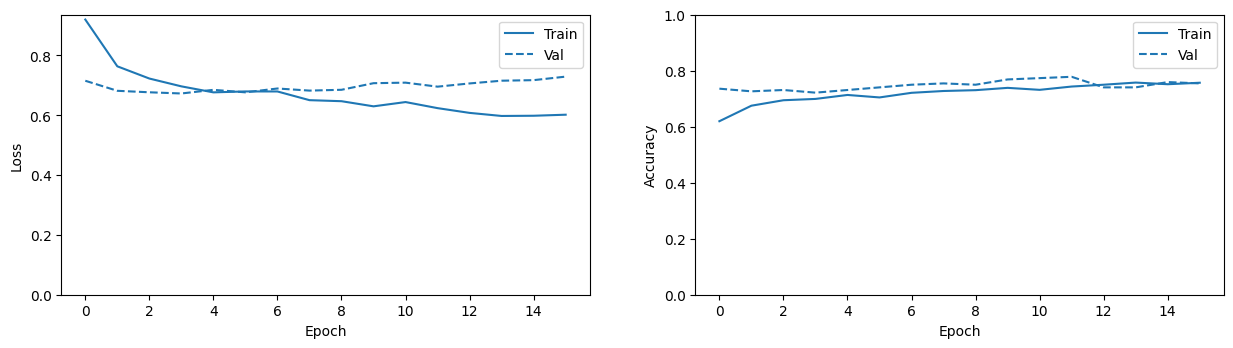

In [32]:
plot_metrics(history_hypermodel)
print("=============================================================================")

In [33]:
model.save(model_tuned_dir)
# quit()

INFO:tensorflow:Assets written to: tuned_model\assets


INFO:tensorflow:Assets written to: tuned_model\assets


In [34]:
reloaded_model = tf.keras.models.load_model(model_tuned_dir)
#label_multi_severity
sample={"sla":"24x7 4Hrs Response Time",
        "product_type":"Server",
        "brand":"VMWare",                
        "service_type":"Incident",
        "incident_type":"General Incident",
        "open_to_close_hour":10,
        "response_to_resolved_hour":8.000000 \
       }

print(sample)
              
print("===============================================================================================================")    
print("convert pain data to serdor as input to predict")    
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
print(input_dict)

predictionList = reloaded_model.predict(input_dict)
print(predictionList)
prob = tf.nn.sigmoid(predictionList[0])
print(f"{(100 * prob)} %  as Severity") 

{'sla': '24x7 4Hrs Response Time', 'product_type': 'Server', 'brand': 'VMWare', 'service_type': 'Incident', 'incident_type': 'General Incident', 'open_to_close_hour': 10, 'response_to_resolved_hour': 8.0}
convert pain data to serdor as input to predict
{'sla': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'24x7 4Hrs Response Time'], dtype=object)>, 'product_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Server'], dtype=object)>, 'brand': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'VMWare'], dtype=object)>, 'service_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Incident'], dtype=object)>, 'incident_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'General Incident'], dtype=object)>, 'open_to_close_hour': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([10])>, 'response_to_resolved_hour': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.], dtype=float32)>}
1/1 [==============================] - 1s 825ms/step
[[0.00444075 0.1758255

# Copy Model From Local To GCS

In [94]:
# #https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#6
# press_y3=input(f"Press y=True to save model to Google Cloud storage : ") 
# if press_y3.lower()=='y':
#     MODEL_BUCKET = 'gs://tf1-incident-pongthorn'
#     MODEL_NAME = 'tf1_incident_multi_model'

# # !gsutil mb -l $REGION $MODEL_BUCKET
# # !gsutil -m cp -r ./$model_tuned_dir/* $MODEL_BUCKET/model
# else:
#  quite()


Copying file://.\model\saved_model.pb [Content-Type=application/octet-stream]...
Copying file://.\model\variables\variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
Copying file://.\model\fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://.\model\keras_metadata.pb [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
Copying file://.\model\variables\variables.index [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
/ [1/5 files][ 97.0 KiB/527.8 KiB]  18% Done                                    
/ [2/5 files][ 97.0 KiB/527.8 KiB]  18% Done                          

# Import Model to Vertex AI

In [ ]:
# https://cloud.google.com/vertex-ai/docs/model-registry/import-model#get-operation

#https://codelabs.developers.google.com/vertex-p2p-predictions#3
# Import model manually
#https://console.cloud.google.com/vertex-ai/models?project=pongthorn
# Upload wand wait for vertex to complete process (Email notification)
# if run package ( you need to specify precuild-pacage


#Import model programactically
# https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers

# from google.cloud import aiplatform
# DEPLOY_IMAGE = "asia-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-6:latest"

# model = aip.Model.upload(
#     display_name="ponghthorn_xgb_" + TIMESTAMP,
#     artifact_uri=MODEL_DIR,
#     serving_container_image_uri=DEPLOY_IMAGE,
#     sync=False,
# )

# model.wait()


# Deploy Model to EndPoint

In [ ]:
#https://codelabs.developers.google.com/vertex-p2p-predictions#4
# Manual

# Program
# my_model = aiplatform.Model("projects/{PROJECT_NUMBER}/locations/us-central1/models/{MODEL_ID}") 

# endpoint = my_model.deploy(
#      deployed_model_display_name='my-endpoint',
#      traffic_split={"0": 100},
#      machine_type="n1-standard-4",
#      accelerator_count=0,
#      min_replica_count=1,
#      max_replica_count=1,
#    )

In [95]:
# Deploy to AIPlatform (Deprecated)
# MODEL = MODEL_NAME
# VERSION = 'v1'
# model_path = MODEL_BUCKET + '/model'

# # !gcloud ai-platform models create $MODEL --region=$REGION

# MACHINE_TYPE='n1-standard-2'

# !gcloud  ai-platform versions create $VERSION --model $MODEL --origin $model_path --runtime-version 2.11 --framework TENSORFLOW --machine-type $MACHINE_TYPE --python-version 3.7 --region=$REGION
# !gcloud ai-platform versions describe $VERSION --model $MODEL --region=$REGION